# Training the REAL/FAKE classifier

In [1]:
from fastai.core import *
from fastai.vision import *
from efficientnet_pytorch import EfficientNet

In [2]:
path = Path('../data/EasyDeepFakes')
src = ImageList.from_folder(path).split_by_folder(train='train', valid='val')

In [3]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).png$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

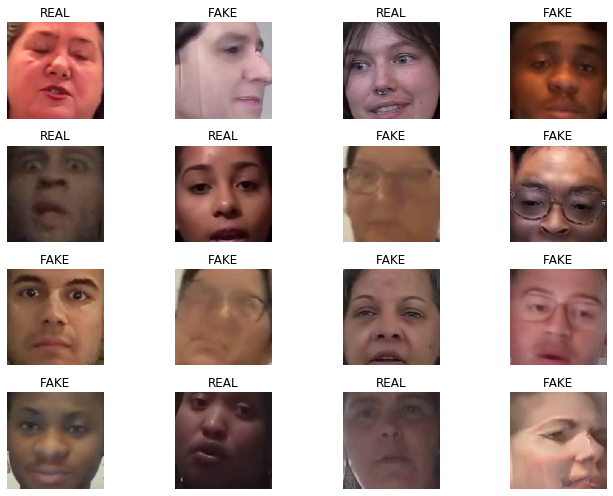

In [4]:
bs, sz = 32, 256
data = get_data(bs, sz)
data.show_batch(rows=4, figsize=(10,7))

# EfficientNet

EfficientNet is an architecture released by Google with the intention of reducing the number of parameters while maintaining good performance. There are 8 versions of Efficient with increasing capacity from `efficientb0` to `efficientnetb7`.

I haven't figured out how to set up layer groups so I'm unable to do discriminitive learning with EfficientNet, but we'll give it a shot anyways.

## EfficientNetB0

### Transfer from Imagenet

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [6]:
learn = Learner(data, model, metrics=[accuracy]).to_fp16()

In [7]:
fm = flatten_model(model)
learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [8]:
learn.freeze_to(-1)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


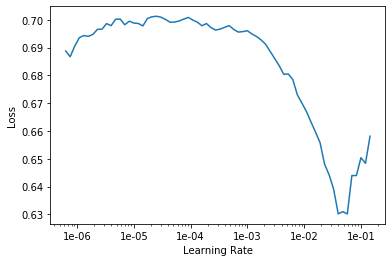

In [14]:
learn.recorder.plot(skip_end=10)

In [15]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.617744,0.752598,0.610127,00:09
1,0.457196,1.634969,0.564557,00:09
2,0.347240,2.463516,0.511392,00:09
3,0.220700,1.524742,0.587342,00:09
4,0.166339,0.919773,0.675949,00:09
5,0.122946,0.688545,0.827848,00:09
6,0.082851,1.569407,0.683544,00:09
7,0.069489,0.493424,0.835443,00:09
8,0.065225,0.345136,0.875949,00:09
9,0.047185,0.329459,0.875949,00:09


In [16]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


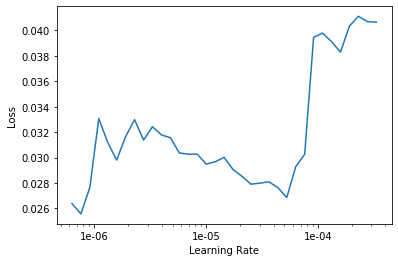

In [21]:
learn.recorder.plot(skip_end=10)

In [25]:
learn.fit_one_cycle(cyc_len=20, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.028184,0.340965,0.888608,00:13
1,0.034338,0.322491,0.893671,00:13
2,0.030835,0.359860,0.896203,00:13
3,0.030754,0.351067,0.893671,00:13
4,0.025589,0.426322,0.888608,00:13
5,0.028927,0.510527,0.868354,00:13
6,0.034488,0.501700,0.883544,00:13
7,0.029113,0.453318,0.898734,00:13
8,0.028673,0.289805,0.916456,00:13
9,0.026317,0.298830,0.903797,00:13


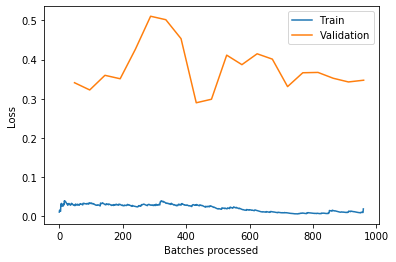

In [26]:
learn.recorder.plot_losses()

In [31]:
learn.save('effnet_classifier_fromimagenette')

In [35]:
learn.path

PosixPath('../data/EasyDeepFakes')

### Transfer from Embedding Learning

In [32]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [33]:
swish0 = model._swish
fc0 = model._fc
dropout0 = model._dropout

In [34]:
model._swish = nn.Identity()
model._fc = nn.Identity()
model._dropout = nn.Identity()

In [37]:
state_dict = torch.load('../nbs/models/effnet_oselect.pth')

In [38]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [39]:
model._swish = swish0
model._fc = fc0
model._dropout = dropout0

In [40]:
learn = Learner(data, model, metrics=[accuracy]).to_fp16()

In [41]:
fm = flatten_model(model)
learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [42]:
learn.freeze_to(-1)

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


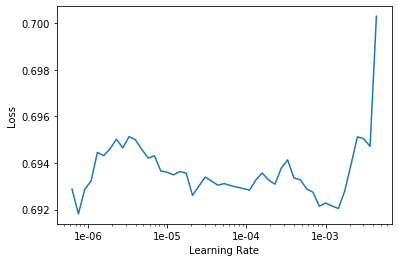

In [46]:
learn.recorder.plot(skip_end=30)

In [47]:
learn.fit_one_cycle(cyc_len=10, max_lr=5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.693688,0.695751,0.506329,00:10
1,0.695726,0.717812,0.506329,00:10
2,0.695767,0.691275,0.493671,00:10
3,0.694390,0.681157,0.511392,00:10
4,0.685264,0.663359,0.655696,00:10
5,0.668131,0.660678,0.498734,00:10
6,0.648617,0.625602,0.617721,00:10
7,0.631514,0.617349,0.615190,00:10
8,0.619939,0.608947,0.617721,00:10
9,0.612410,0.607374,0.635443,00:10


In [48]:
learn.unfreeze()

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


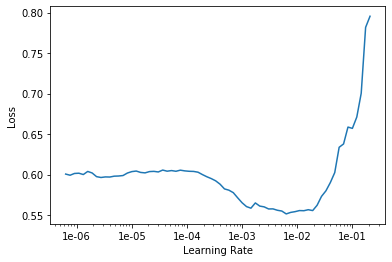

In [51]:
learn.recorder.plot(skip_end=10)

In [52]:
learn.fit_one_cycle(cyc_len=20, max_lr=[1e-3, 1e-2])

epoch,train_loss,valid_loss,accuracy,time
0,0.529253,0.813746,0.592405,00:13
1,0.397845,0.861373,0.546835,00:13
2,0.304169,1.214033,0.668354,00:13
3,0.251246,1.639008,0.574684,00:13
4,0.241805,0.406727,0.782278,00:13
5,0.193272,0.894612,0.820253,00:13
6,0.159519,0.602929,0.807595,00:13
7,0.130728,0.758375,0.822785,00:13
8,0.088919,0.345557,0.883544,00:13
9,0.105122,0.739556,0.800000,00:13


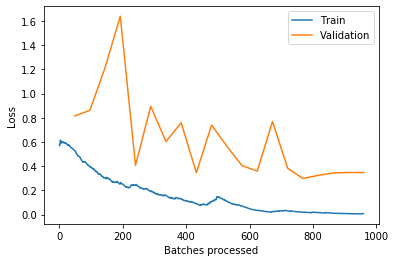

In [53]:
learn.recorder.plot_losses()

In [54]:
learn.save('effnet_classifier_fromoselect')

# -fin